# Behavior of $\epsilon \mapsto \psi^\epsilon$

In [1]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import matplotlib.pylab as pl
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
from scipy.integrate import quad
from scipy.optimize import minimize

parameters = {'axes.labelsize': 20,
             'axes.titlesize': 27,
             'legend.fontsize': 20}
plt.rcParams.update(parameters)

# Resolution of unregularized OT

Let $\rho$ be a probability density on $[m, M]$ and $\mu$ a discrete probability measure with support of size $N$.

We solve the following optimization problem:

$$ (1) \qquad \min_{\psi \in \mathbb{R}^N} F(\psi), $$
where $$F(\psi) = \int_m^M \psi^*(x) \rho(x)dx + \langle \psi, \mu \rangle.$$
The function $F$ is convex on $\mathbb{R}^N$ and stricly convex on $(\mathbb{1}_N)^\perp$. Its gradient reads:
$$ \frac{ \partial F}{\partial \psi_i} (\psi) = \mu_i - \int_{Lag_i(\psi)} \rho(x) dx.$$

Both the cost function $F$ and the gradient $\nabla F = (\frac{ \partial F}{\partial \psi_i})_{i=1, \dots, N}$ are computed using ```scipy.integrate.quad```.

We solve $(1)$ using ```scipy.optimize.minimize``` with the BFGS method.

In [2]:
def h(x, j, psi, rho, b, Y_target):
    if j==np.argmax(x*Y_target - psi): pi=1
    else: pi=0
    return (b[j] - pi)*rho(x)

def f(x, psi, rho, b, Y_target):
    return np.max(x*Y_target - psi)*rho(x)

def get_cost_unreg(psi, rho, m, M, b, Y_target):
    A = quad(f, m, M, args=(psi, rho, b, Y_target), limit=100, epsabs=1e-18, epsrel=1e-18)[0]
    B = np.sum(b*psi)
    return A + B

def gradient_unreg(psi, rho, m, M, b, Y_target):
    grad = np.zeros(len(Y_target))
    for j in range(len(Y_target)):
        grad[j] = quad(h, m, M, args=(j, psi, rho, b, Y_target), limit=100, epsabs=1e-18, epsrel=1e-18)[0]
    return grad

def solve_ot_unreg(psi_init, rho, m, M, b, Y_target, disp=False):
    res = minimize(get_cost_unreg, psi_init, args=(rho, m, M, b, Y_target), method='L-BFGS-B',\
                   jac=gradient_unreg, tol=None, options={'ftol': 1e-16, 'gtol': 1e-16,\
                                                                 'maxiter':1000000, 'maxfun': 1000000,\
                                                                 'maxls':50})

    if disp:
        print("Final gradient:", gradient_unreg(res['x'], rho, m, M, b, Y_target))
        print("Cost:", get_cost_unreg(res['x'], rho, m, M, b, Y_target))
        
    return res['x'] - (1/len(b))*np.sum(res['x'])

# Resolution of regularized OT

Here we solve the following optimization problem:

$$ (2) \qquad \min_{\psi \in \mathbb{R}^N} F^\epsilon(\psi), $$
where $$F^\epsilon(\psi) = \int_{m}^M \epsilon \log \left( \sum_{i=1}^N e^{\frac{xy_i - \psi_i}{\epsilon}} \right) \rho(x)dx + \langle \psi, \mu \rangle + \epsilon = \int_{m}^M  f^\epsilon(x, \psi) dx + \langle \psi, \mu \rangle + \epsilon.$$
The function $F^\epsilon$ is convex on $\mathbb{R}^N$ and stricly convex on $(\mathbb{1}_N)^\perp$. Its gradient reads:
$$ \frac{ \partial F^\epsilon}{\partial \psi_i} (\psi) = \mu - \int_0^1 \frac{ e^{\frac{xy_i - \psi_i}{\epsilon}} }{ \sum_{j=1}^N e^{\frac{xy_j - \psi_j}{\epsilon}} } \rho(x) dx.$$

Both the cost function $F^\epsilon$ and the gradient $\nabla F^\epsilon = (\frac{ \partial F^\epsilon}{\partial \psi_i})_{i=1, \dots, N}$ are computed using ```scipy.integrate.quad```.

We solve $(2)$ using ```scipy.optimize.minimize``` with the BFGS method.

In [3]:
def hr(x, j, psi, eps, rho, b, Y_target):
    r = (x*Y_target - psi)/eps
    r -= np.max(r)
    pi = np.exp(r)/np.sum(np.exp(r))
    return (b - pi).flatten()[j]*rho(x)

def fr(x, psi, eps, rho, b, Y_target):
    r = x*Y_target - psi
    max_r = np.max(r)
    r -= max_r
    return (max_r + eps*np.log(np.sum(np.exp(r/eps))))*rho(x)

def get_cost_reg(psi, eps, rho, m, M, b, Y_target):
    A = quad(fr, m, M, args=(psi, eps, rho, b, Y_target), limit=100, epsabs=1e-18, epsrel=1e-18)[0]
    B = np.sum(b*psi)
    return A + B + eps

def gradient_reg(psi, eps, rho, m, M, b, Y_target):
    grad = np.zeros(len(Y_target))
    for j in range(len(Y_target)):
        grad[j] = quad(hr, m, M, args=(j, psi, eps, rho, b, Y_target), limit=100, epsabs=1e-18, epsrel=1e-18)[0]
    return grad

def solve_ot_reg(psi_init, eps, rho, m, M, b, Y_target, disp=False):
    res = minimize(get_cost_reg, psi_init, args=(eps, rho, m, M, b, Y_target), \
                   method='L-BFGS-B', jac=gradient_reg, options={'ftol': 1e-16, 'gtol': 1e-16,\
                                                                 'maxiter':10000000, 'maxfun': 10000000,\
                                                                 'maxls':100})
    if disp:
        print("Final gradient:", gradient_reg(res['x'], eps, rho, m, M, b, Y_target))
        print("Cost:", get_cost_reg(res['x'], eps, rho, m, M, b, Y_target))
        
    return res['x'] - (1/len(b))*np.sum(res['x'])

# Computation of $\dot{\psi^\epsilon}$

Compute the *true* derivatives using the formula
$$ \dot{\psi^\epsilon} = - \left( \int_m^M M(\pi^\epsilon_x) \rho(x) dx \right)^{-1} \left( \int_m^M M(\pi^\epsilon_x) \log \pi^\epsilon_x \rho(x) dx \right),$$
where $M(\pi^\epsilon_x) = \mathrm{diag}(\pi^\epsilon_x) - \pi^\epsilon_x (\pi^\epsilon_x)^\top$.

In [4]:
def M_ij(x, i, j, psi, eps, rho, b, Y_target): 
    r = (x*Y_target - psi)/eps
    r -= np.max(r)
    pi = np.exp(r)/np.sum(np.exp(r))
    if i==j:
        return pi[i]*(1 - pi[i])*rho(x)
    else:
        return -pi[i]*pi[j]*rho(x)
    
def Mlog_i(x, i, psi, eps, rho, b, Y_target): 
    n_target = len(Y_target)
    r = (x*Y_target - psi)/eps
    r -= np.max(r)
    pi = np.exp(r)/np.sum(np.exp(r))
    M_i = np.zeros(n_target)
    for j in range(n_target):
        if j==i: M_i[j] = pi[i]*(1 - pi[i])
        else: M_i[j] = -pi[i]*pi[j]
    return np.sum(M_i*r)*rho(x)

def Hessian_K_eps(psi, eps, rho, m, M, b, Y_target):
    n_target = len(Y_target)
    mat = np.zeros((n_target, n_target))
    for i in range(n_target):
        mat[i, i] = quad(M_ij, m, M, args=(i, i, psi, eps, rho, b, Y_target), limit=100,\
                         epsabs=1e-18, epsrel=1e-18)[0]
        for j in range(i+1, n_target):
            mat[i, j] = quad(M_ij, m, M, args=(i, j, psi, eps, rho, b, Y_target), limit=100,\
                             epsabs=1e-18, epsrel=1e-18)[0]
            mat[j, i] = mat[i, j]
    return (1/eps)*mat



def der_epsilon_K_eps(psi, eps, rho, m, M, b, Y_target):
    n_target = len(Y_target)
    vect = np.zeros(n_target)
    for i in range(n_target):
        vect[i] = quad(Mlog_i, m, M, args=(i, psi, eps, rho, b, Y_target), limit=100,\
                       epsabs=1e-18, epsrel=1e-18)[0]
    return (1/eps)*vect

def get_dot_psi(psi, eps, rho, m, M, b, Y_target):
    mat = Hessian_K_eps(psi, eps, rho, m, M, b, Y_target)
    vect = der_epsilon_K_eps(psi, eps, rho, m, M, b, Y_target)
    dot_psi = np.linalg.lstsq(mat, -vect)[0] 
    return dot_psi - (1/n_target)*np.sum(dot_psi)

# Gaussian source

* $\rho$ is a rescaled gaussian distribution
* $\mu = \frac{1}{5} \sum_{i=1}^{5} \delta_{y_i}$ is a uniform discrete measure with support of size $5$ included in $[m, M]$. We denote $N=5$.

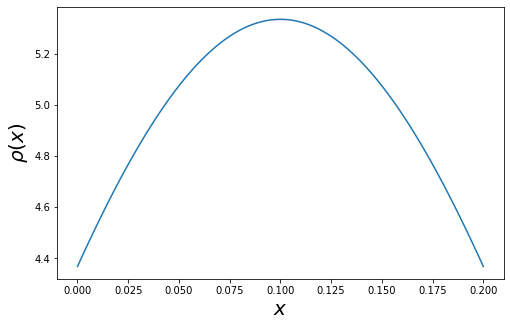

In [5]:
m, M = 0, 0.2 #25
sigma = 5e-2 #1e-1

integrand = lambda u: np.exp(-(u - (m+M)/2)**2/sigma)
int_integrand = quad(integrand, m, M)[0]

def rho(x):    
    return integrand(x)/int_integrand

plt.rcParams["figure.figsize"] = (8, 5)
xx = np.linspace(m, M, 100)
plt.plot(xx, rho(xx))
plt.xlabel("$x$")
plt.ylabel(r"$\rho(x)$")
plt.show()

Y = [0.03120373 0.07490802 0.1197317  0.14639879 0.19014286]


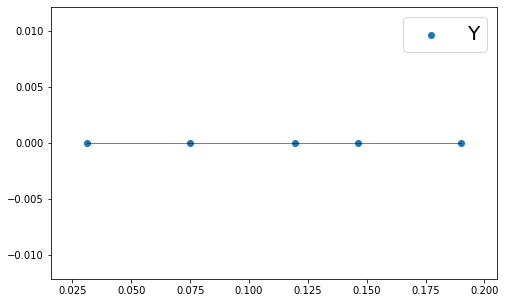

In [6]:
n_target = 5
b = np.ones(n_target)/n_target
rng = np.random.RandomState(42)
Y_target = np.sort(rng.rand(n_target))
Y_target = (M-m)*Y_target + m
print("Y =", Y_target)

plt.scatter(Y_target, np.zeros(n_target), label="Y")
plt.plot(Y_target, np.zeros(n_target), c="k", lw=0.5)
plt.legend()
plt.show()

Solve unregularized OT:

In [7]:
psi_init = np.zeros(len(b))
psi_0 = solve_ot_unreg(psi_init, rho, m, M, b, Y_target)

print("psi_0:", psi_0)

/home/alex/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  # Remove the CWD from sys.path while we load stuff.
/home/alex/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
/home/alex/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
/home/alex/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (i

psi_0: [-0.00631592 -0.00445716 -0.0008169   0.00235081  0.00923917]


Test resolution of regularized OT with $\epsilon$ small:

In [8]:
psi_init = np.zeros(len(b))
eps = 1e-3

psi_eps = solve_ot_reg(psi_init, eps, rho, m, M, b, Y_target)

print("psi_eps:", psi_eps)

/home/alex/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  
/home/alex/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.


psi_eps: [-0.00643205 -0.00444113 -0.00071429  0.0024652   0.00912228]


Observe the functions $x \mapsto \pi^\epsilon_{i, x}$ for $i \in \{1, \dots, N\}$:

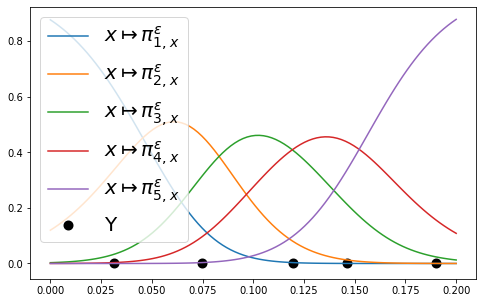

In [9]:
def pi_eps(x, i, psi, eps, b, Y_target):
    r = (x*Y_target - psi)/eps
    r -= np.max(r)
    pi = np.exp(r)/np.sum(np.exp(r))
    return pi[i]

xx = np.linspace(m, M, 100)
for i in range(n_target):
    pi_i = np.array([pi_eps(x, i, psi_eps, eps, b, Y_target) for x in xx])
    title = r"$x \mapsto \pi^\epsilon_{" + str(i+1) + ", x}$"
    plt.plot(xx, pi_i, label=title)
    
plt.scatter(Y_target, np.zeros(n_target), label="Y", lw=4, c="k")
plt.legend()
#plt.savefig('outputs/example-pi-eps-1e-3-gaussian.pdf', bbox_inches='tight')   
plt.show()

## Behavior for $\epsilon \to 0$:

In [10]:
nb_eps = 30
epsilons = np.logspace(-3.5, 1.3, nb_eps) 
log_psi = np.zeros((n_target, nb_eps))

for i in range(nb_eps):
    eps = epsilons[nb_eps - 1 - i]
    print("i = {} - epsilon = {}".format(i, eps))
    
    # initialize potential
    if i==0: psi_init = np.zeros(n_target)
    else: psi_init = log_psi[:, nb_eps - i].copy()
    
    # compute potential 
    log_psi[:, nb_eps - 1 - i] = solve_ot_reg(psi_init, eps, rho, m, M, b, Y_target)

i = 0 - epsilon = 19.952623149688797
i = 1 - epsilon = 13.629588960158873
i = 2 - epsilon = 9.31033948916044
i = 3 - epsilon = 6.359870547586188
i = 4 - epsilon = 4.3444122987293685
i = 5 - epsilon = 2.9676576087722926
i = 6 - epsilon = 2.0271997861436666
i = 7 - epsilon = 1.3847753058820778
i = 8 - epsilon = 0.9459366861066257
i = 9 - epsilon = 0.646167078746697
i = 10 - epsilon = 0.44139517981330934
i = 11 - epsilon = 0.30151598738257357
i = 12 - epsilon = 0.20596484693317238
i = 13 - epsilon = 0.1406940923446931
i = 14 - epsilon = 0.09610779662375922
i = 15 - epsilon = 0.06565100508445242


/home/alex/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  
/home/alex/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.


i = 16 - epsilon = 0.044846043921615474
i = 17 - epsilon = 0.030634224911443953
i = 18 - epsilon = 0.020926165473262724
i = 19 - epsilon = 0.014294613383568447
i = 20 - epsilon = 0.009764616075829726
i = 21 - epsilon = 0.006670185793059216
i = 22 - epsilon = 0.004556387897733956
i = 23 - epsilon = 0.003112457631423004
i = 24 - epsilon = 0.0021261123338996556
i = 25 - epsilon = 0.0014523422297297447
i = 26 - epsilon = 0.000992091489534587
i = 27 - epsilon = 0.0006776953141341246
i = 28 - epsilon = 0.00046293204169587727
i = 29 - epsilon = 0.00031622776601683794


### Observe behavior w.r.t. $\epsilon$

We can first observe the rate of convergence of $\psi^\epsilon$ to $\psi^0$ as $\epsilon$ goes to $0$.

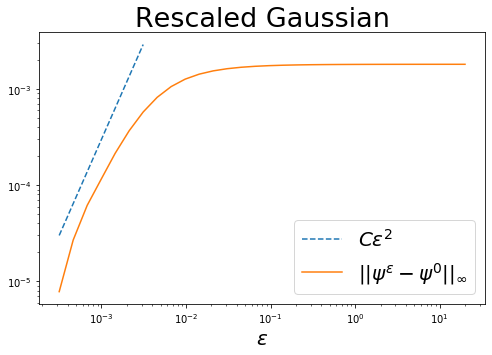

In [11]:
differences_psi = np.linalg.norm(log_psi - psi_0.reshape((-1, 1)), axis=0, ord=np.inf)

comparison = np.array([3e2*eps**(2) for eps in epsilons])
plt.loglog(epsilons[:7], comparison[:7], "--", label=r"$C\epsilon^{2}$")

plt.loglog(epsilons, differences_psi, label=r"$||\psi^\epsilon - \psi^0||_\infty$")
plt.xlabel(r"$\epsilon$")
plt.title(r"Rescaled Gaussian")
plt.legend()
plt.savefig('outputs/psi-eps-psi-0-gaussian.pdf', bbox_inches='tight')   
plt.show()

Observe Theorem 3.2:

/home/alex/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
/home/alex/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.


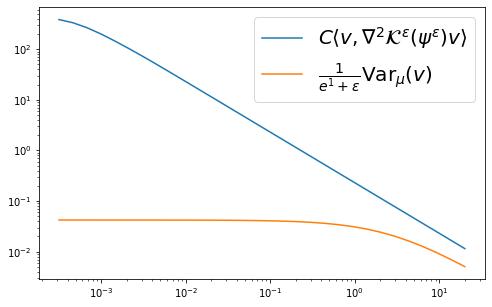

In [12]:
v = np.random.rand(n_target)
var_v = np.var(v)

hessian_products = np.zeros(nb_eps)
for i in range(nb_eps):
    hessian_products[i] = v.dot(Hessian_K_eps(log_psi[:, i], epsilons[i], rho, m, M, b, Y_target).dot(v))
    
plt.loglog(epsilons, 2e0*hessian_products, label=r'$C\langle v, \nabla^2 \mathcal{K}^\epsilon (\psi^\epsilon) v\rangle$')
plt.loglog(epsilons, var_v/(np.exp(1)+epsilons), label=r'$\frac{1}{e^1 + \epsilon} \mathrm{Var}_\mu(v)$')
plt.legend()
#plt.savefig('outputs/strong-convexity-gaussian.pdf', bbox_inches='tight')  
plt.show()

Observe Theorem 3.3:

/home/alex/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.


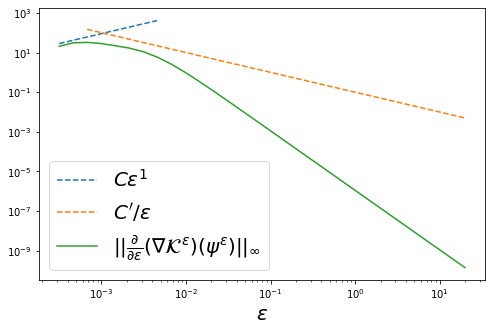

In [13]:
log_der_epsilon_K_eps = np.zeros((n_target, nb_eps))
for i in range(nb_eps):
    log_der_epsilon_K_eps[:, i] = der_epsilon_K_eps(log_psi[:, i], epsilons[i], rho, m, M, b, Y_target) 
    
plt.loglog(epsilons[:8], 9e4*epsilons[:8]**(1), "--", label=r"$C\epsilon^{1}$")
plt.loglog(epsilons[2:], 1e-1/epsilons[2:]**1, "--", label=r"$C'/\epsilon$")

norm_der_epsilon_K_eps = np.linalg.norm(log_der_epsilon_K_eps, axis=0, ord=np.inf)
plt.loglog(epsilons, norm_der_epsilon_K_eps, label=r"$||\frac{\partial}{\partial \epsilon}(\nabla \mathcal{K}^\epsilon)(\psi^\epsilon)||_\infty$")
plt.xlabel(r"$\epsilon$")
plt.legend()
#plt.savefig('outputs/bound-second-term-ode-gaussian.pdf', bbox_inches='tight')  
plt.show()

Observe Theorem 2.1:

/home/alex/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
/home/alex/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
/home/alex/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
/home/alex/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we 

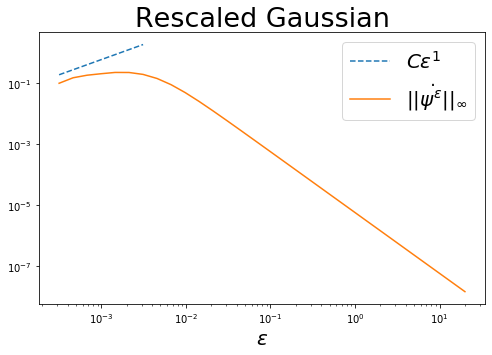

In [14]:
log_dot_psi = np.zeros((n_target, nb_eps))
for i in range(nb_eps):
    log_dot_psi[:, i] = get_dot_psi(log_psi[:, i], epsilons[i], rho, m, M, b, Y_target)

plt.loglog(epsilons[:7], 6e2*epsilons[:7]**(1), "--", label=r"$C\epsilon^{1}$")

norm_derivatives_psi = np.linalg.norm(log_dot_psi, axis=0, ord=np.inf)
plt.loglog(epsilons, norm_derivatives_psi, label=r"$||\dot{\psi^{\epsilon}}||_\infty$")
plt.xlabel(r"$\epsilon$")
plt.title(r"Rescaled Gaussian")
plt.legend()
plt.savefig('outputs/dot-psi-gaussian.pdf', bbox_inches='tight')  
plt.show()

Observe exponential convergence of $\epsilon \mapsto \pi^\epsilon_{x,i}$ for all $i \in \{1, \dots, N\}$ and $\rho$-almost-every $x \in \mathcal{X}$.

x = 0.031198904067240532


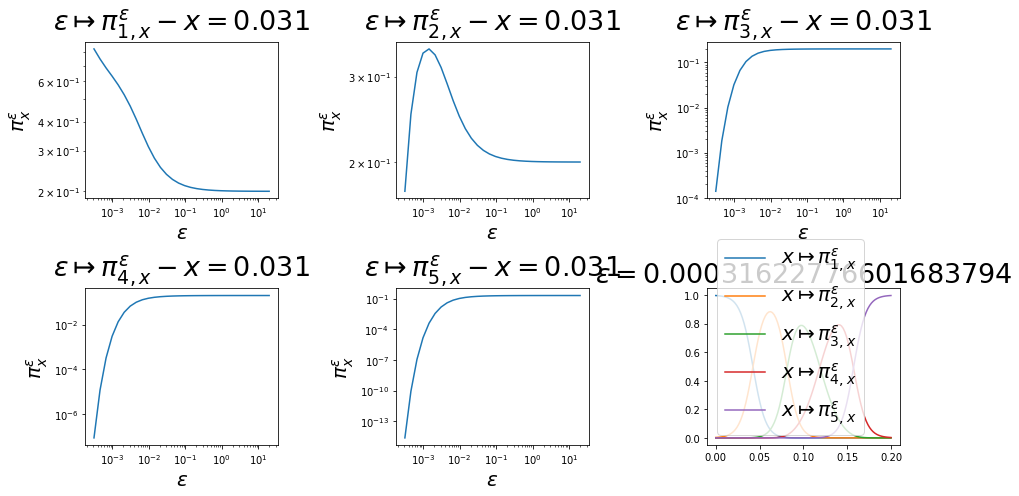

In [15]:
x = (M-m)*rng.rand() + m

print("x = {}".format(x))
log_pi_x = np.zeros((n_target, nb_eps))

for e in range(nb_eps):
    for i in range(n_target):
        log_pi_x[i, e] = pi_eps(x, i, log_psi[:, e], epsilons[e], b, Y_target)
        

plt.figure(figsize=(14, 7))
           
for i in range(n_target):
    plt.subplot(2, 3, i+1)
    plt.loglog(epsilons, log_pi_x[i])
    plt.title(r"$\epsilon \mapsto \pi^\epsilon_{" + str(i+1) + ", x} - x = $" + str(round(x, 3)))
    plt.xlabel(r"$\epsilon$")
    plt.ylabel(r"$\pi^\epsilon_x$")

plt.subplot(2, 3, 6)
xx = np.linspace(m, M, 100)
for i in range(n_target):
    pi_i = np.array([pi_eps(x, i, log_psi[:, 0], epsilons[0], b, Y_target) for x in xx])
    title = r"$x \mapsto \pi^\epsilon_{" + str(i+1) + ", x}$" 
    plt.plot(xx, pi_i, label=title)
    
plt.title(r"$\epsilon = $" + str(epsilons[0]))

plt.tight_layout()
plt.legend()
#plt.savefig('outputs/pi-eps-x-vs-eps-0-gaussian.pdf', bbox_inches='tight')  
plt.show()

## Behavior for $\epsilon \to \infty$ with $\mu$ non-uniform:

In [16]:
b = np.random.rand(n_target)
b /= np.sum(b)
nb_eps = 30
epsilons = np.logspace(.5, 4, nb_eps)
log_psi = np.zeros((n_target, nb_eps))

for i in range(nb_eps):
    eps = epsilons[nb_eps - 1 - i]
    print("i = {} - epsilon = {}".format(i, eps))
    
    # initialize potential
    if i==0: psi_init = np.zeros(n_target)
    else: psi_init = log_psi[:, nb_eps - i].copy()
    
    # compute potential 
    log_psi[:, nb_eps - 1 - i] = solve_ot_reg(psi_init, eps, rho, m, M, b, Y_target)

i = 0 - epsilon = 10000.0
i = 1 - epsilon = 7573.739175895009
i = 2 - epsilon = 5736.152510448682
i = 3 - epsilon = 4344.412298729369
i = 4 - epsilon = 3290.3445623126677


/home/alex/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  
/home/alex/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.


i = 5 - epsilon = 2492.021151378057
i = 6 - epsilon = 1887.3918221350978
i = 7 - epsilon = 1429.4613383568455
i = 8 - epsilon = 1082.6367338740552
i = 9 - epsilon = 819.9608244604942
i = 10 - epsilon = 621.0169418915616
i = 11 - epsilon = 470.3420341698635
i = 12 - epsilon = 356.2247890262444
i = 13 - epsilon = 269.7953640073002
i = 14 - epsilon = 204.33597178569437
i = 15 - epsilon = 154.75873545578892
i = 16 - epsilon = 117.21022975334806
i = 17 - epsilon = 88.77197088985865
i = 18 - epsilon = 67.23357536499338
i = 19 - epsilon = 50.92095636773397
i = 20 - epsilon = 38.56620421163472
i = 21 - epsilon = 29.2090371703225
i = 22 - epsilon = 22.122162910704493
i = 23 - epsilon = 16.754749189233408
i = 24 - epsilon = 12.689610031679221
i = 25 - epsilon = 9.610779662375922
i = 26 - epsilon = 7.27895384398315
i = 27 - epsilon = 5.512889788770675
i = 28 - epsilon = 4.1753189365604015
i = 29 - epsilon = 3.1622776601683795


### Observe behavior w.r.t. $\epsilon$

Observe Theorem 3.2:

/home/alex/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
/home/alex/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.


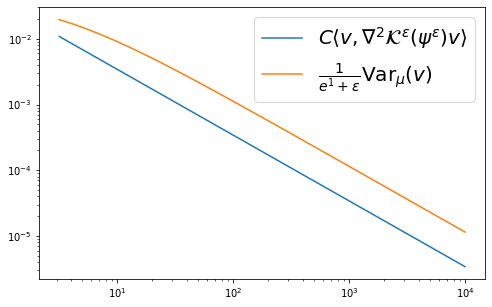

In [17]:
v = np.random.rand(n_target)
var_v = np.var(v)

hessian_products = np.zeros(nb_eps)
for i in range(nb_eps):
    hessian_products[i] = v.dot(Hessian_K_eps(log_psi[:, i], epsilons[i], rho, m, M, b, Y_target).dot(v))
    
plt.loglog(epsilons, 2e0*hessian_products, label=r'$C\langle v, \nabla^2 \mathcal{K}^\epsilon (\psi^\epsilon) v\rangle$')
plt.loglog(epsilons, var_v/(np.exp(1)+epsilons), label=r'$\frac{1}{e^1 + \epsilon} \mathrm{Var}_\mu(v)$')
plt.legend()
plt.show()

Observe Theorem 3.3:

/home/alex/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.


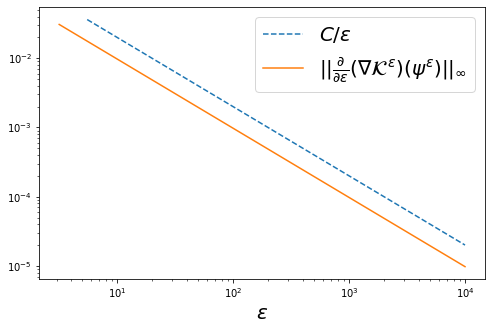

In [18]:
log_der_epsilon_K_eps = np.zeros((n_target, nb_eps))
for i in range(nb_eps):
    log_der_epsilon_K_eps[:, i] = der_epsilon_K_eps(log_psi[:, i], epsilons[i], rho, m, M, b, Y_target) 
    
plt.loglog(epsilons[2:], 2e-1/epsilons[2:]**1, "--", label=r"$C/\epsilon$")

norm_der_epsilon_K_eps = np.linalg.norm(log_der_epsilon_K_eps, axis=0, ord=np.inf)
plt.loglog(epsilons, norm_der_epsilon_K_eps, label=r"$||\frac{\partial}{\partial \epsilon}(\nabla \mathcal{K}^\epsilon)(\psi^\epsilon)||_\infty$")
plt.xlabel(r"$\epsilon$")
plt.legend()
plt.show()

Observe Theorem 2.1:

/home/alex/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
/home/alex/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
/home/alex/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
/home/alex/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we 

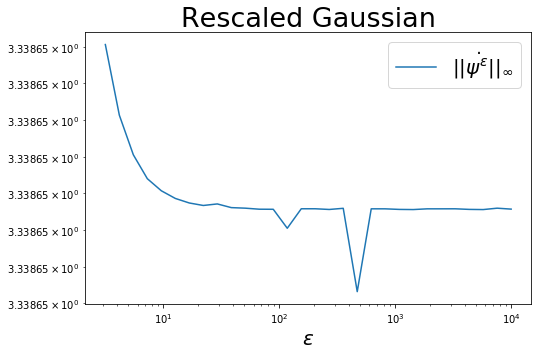

In [19]:
log_dot_psi = np.zeros((n_target, nb_eps))
for i in range(nb_eps):
    log_dot_psi[:, i] = get_dot_psi(log_psi[:, i], epsilons[i], rho, m, M, b, Y_target)


norm_derivatives_psi = np.linalg.norm(log_dot_psi, axis=0, ord=np.inf)
plt.loglog(epsilons, norm_derivatives_psi, label=r"$||\dot{\psi^{\epsilon}}||_\infty$")
plt.xlabel(r"$\epsilon$")
plt.title(r"Rescaled Gaussian")
plt.legend()
plt.show()